In [1]:
import h5py, sys, os
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.animation as animation
from datetime import datetime
from scipy.interpolate import griddata

print(os.getcwd())

%matplotlib widget

from jfunctions import *

# Get directory locations from param file
base_dir, run_dir, save_dir, version = read_params("./params.dat")

/mhome/damtp/q/cwp29/diablo3/proc/jupyter


In [2]:
#Load simulation data
b, phi_v, phi_c, u, v, w, times = load_data('th1_xz', 'th2_xz', 'th3_xz', 'u_xz', 'v_xz', 'w_xz')
NSAMP = len(times)

times, t0_idx = calibrate_time(save_dir, times)

b_az, w_az, phiv_az, phic_az = load_az_data('b_az', 'w_az', 'phiv_az', 'phic_az')

# Load simulation metadata
md = get_metadata()

# Load grids
gxf, gyf, gzf, dzf = get_grid(md)
gx, gy, gz, dz = get_grid(md, fractional_grid=False)

Keys: <KeysViewHDF5 ['B_xy', 'B_xz', 'B_yz', 'Ent_phic_flux_int', 'Ent_phic_flux_rec', 'Ent_phiv_flux_int', 'Ent_phiv_flux_rec', 'N2_xy', 'N2_xz', 'N2_yz', 'Re_b_xy', 'Re_b_xz', 'Re_b_yz', 'Ri_xy', 'Ri_xz', 'Ri_yz', 'b_phic_F1', 'b_phic_F3', 'b_phic_M', 'b_phic_S', 'b_phic_W', 'b_phiv_F1', 'b_phiv_F2', 'b_phiv_M', 'b_phiv_S', 'b_phiv_W', 'chi1_xy', 'chi1_xz', 'chi1_yz', 'chi2_xy', 'chi2_xz', 'chi2_yz', 'chi3_xy', 'chi3_xz', 'chi3_yz', 'diff_th1_xy', 'diff_th1_xz', 'diff_th1_yz', 'diff_th2_xy', 'diff_th2_xz', 'diff_th2_yz', 'diff_th3_xy', 'diff_th3_xz', 'diff_th3_yz', 'epsilon_xy', 'epsilon_xz', 'epsilon_yz', 'kappa_t1_xy', 'kappa_t1_xz', 'kappa_t1_yz', 'kappa_t2_xy', 'kappa_t2_xz', 'kappa_t2_yz', 'kappa_t3_xy', 'kappa_t3_xz', 'kappa_t3_yz', 'nu_t_xy', 'nu_t_xz', 'nu_t_yz', 'omegaX_xy', 'omegaX_xz', 'omegaX_yz', 'omegaY_xy', 'omegaY_xz', 'omegaY_yz', 'omegaZ_xy', 'omegaZ_xz', 'omegaZ_yz', 'th1_xy', 'th1_xz', 'th1_yz', 'th2_xy', 'th2_xz', 'th2_yz', 'th3_xy', 'th3_xz', 'th3_yz', 'th_forci

In [3]:
print(md)

{'LX': 0.6, 'LY': 0.6, 'LZ': 0.6, 'RE': 10000000000.0, 'nu': 1e-10, 'SAVE_MOVIE_DT': 0.25, 'SAVE_STATS_DT': 0.25, 'NU_START': 1e-09, 'SAVE_FLOW_DT': 5.0, 'VERSION': 3.11, 'NU_START_TIME': 5.0, 'r0': 0.002, 'alpha_e': 0.11, 'b0': 0.02, 'Lyc': 0.02, 'Lyp': 0.01, 'S_depth': 0.2, 'N2': 1.0, 'H': 0.2, 'b_factor': 0.25, 'phiv_factor': 0.1, 'phic_factor': 3.0, 'Nb': 128.0, 'Nphi': 128.0, 'F_TYPE': 3.0, 'alpha': 67.0, 'beta': 0.51, 'tau': 0.5, 'q0': 0.05, 'phiv_min': 0.0001, 'phic_min': 0.0005, 'Nx': 256, 'Ny': 256, 'Nz': 257, 'Nth': 3}


In [4]:
#Create grid
X, Y = np.meshgrid(gx, gz)
Xf, Yf = np.meshgrid(gxf, gzf)

r_0 = md['r0']
dr = md['LX']/md['Nx']
nbins = int(md['Nx']/2)
r_bins = np.array([r*dr for r in range(0, nbins+1)])
r_points = np.array([0.5*(r_bins[i]+r_bins[i+1]) for i in range(nbins)])

Xa, Ya = np.meshgrid(r_bins, gz)
Xaf, Yaf = np.meshgrid(r_points, gzf)

print("Total time steps: %s"%NSAMP)
print("Dimensional times: ",times)


Total time steps: 62
Dimensional times:  [-5.01302419 -4.76302419 -4.51302419 -4.26302419 -4.01302419 -3.76302419
 -3.51302419 -3.26302419 -3.01302419 -2.76302419 -2.51302419 -2.26302419
 -2.01302419 -1.76302419 -1.51302419 -1.26302419 -1.01302419 -0.76302419
 -0.51302419 -0.26302419 -0.01302419  0.          0.25        0.5
  0.75        1.          1.25        1.5         1.75        2.
  2.25        2.5         2.75        3.          3.25        3.5
  3.75        4.          4.25        4.5         4.75        5.
  5.25        5.5         5.75        6.          6.25        6.5
  6.75        7.          7.25        7.5         7.75        8.
  8.25        8.5         8.75        9.          9.25        9.5
  9.75       10.        ]


In [5]:
# Environmental variables

alpha = md['alpha']
beta = md['beta']
q_0 = md['q0']
T0 = 300 # K

b_env = md['N2'] * (Yf - md['H'])
b_env[gzf < md['H']] = 0

b_az_env = md['N2'] * (Yaf - md['H'])
b_az_env[gzf < md['H']] = 0

T_env = 1340 * (b_env - beta * Yf)

phi_sat = q_0 * np.exp(alpha/1340 * T_env)

T = 1340 * (b - beta * Yf) + T0 - 273.15
theta = 1340 * b + T0

# Relative humidity
r = phi_v/phi_sat

# Total water
phi_t = phi_v + phi_c

In [25]:
# Set up

contours_b = np.linspace(10, 150, 15)*md['N2'] + T0
fn = 8
fnc = 4

steps = [t0_idx+8, t0_idx+16, t0_idx+24]

xstart = get_index(0.2, gxf)-1
xend = get_index(0.4, gxf)+1
zstart = get_index(0.9*md['H'], gzf)-1
zend = get_index(1.5*md['H'], gzf)+1

Xfc, Yfc = np.meshgrid(gxf[xstart:xend], gzf[zstart:zend])
Xfi, Yfi = np.meshgrid(gxf[xstart:xend], np.linspace(gzf[zstart], gzf[zend], zend-zstart))

uc = u[:, zstart:zend, xstart:xend]
wc = w[:, zstart:zend, xstart:xend]
ui = np.zeros_like(uc)
wi = np.zeros_like(wc)

for i in range(NSAMP):
    ui[i] = griddata((Xfc.flatten(), Yfc.flatten()), uc[i].flatten(), (Xfi, Yfi))
    wi[i] = griddata((Xfc.flatten(), Yfc.flatten()), wc[i].flatten(), (Xfi, Yfi))
    

In [32]:
def decorate(fig, axs, step):
    fig.suptitle("t = {0:.2f} s".format(times[step]))

    axs.set_xlim(0.2, 0.4)
    axs.set_ylim(0.9*md['H'], 1.5*md['H'])
    axs.set_aspect(1)

    wvmr_im.set_clim(0, 3)

def decorate_cb(fig, axs, step):
    cb_wvmr = fig.colorbar(wvmr_im, label="wvmr", ax=axs, location='bottom', shrink=0.7)

def plots(fig, axs, step):
    global wvmr_im, theta_contour, cloud_contour, flow
    
    wvmr_im = axs.pcolormesh(X, Y, r[step], cmap='YlGnBu')
    theta_contour = axs.contour(Xf, Yf, theta[step], colors='r', levels=contours_b)
    cloud_contour = axs.contour(Xf, Yf, phi_t[step], colors='k', levels=[md['phic_min']])
    #flow = axs.quiver(Xf[::fn, ::fn], Yf[::fn, ::fn], u[step, ::fn, ::fn], w[-1, ::fn, ::fn])
    flow = axs.streamplot(Xfi[::fnc, ::fnc], Yfi[::fnc, ::fnc], ui[step, ::fnc, ::fnc], wi[step, ::fnc, ::fnc], broken_streamlines=True, density=0.5, 
                          minlength=0.09, maxlength=0.1)
    

    decorate(fig, axs, step)

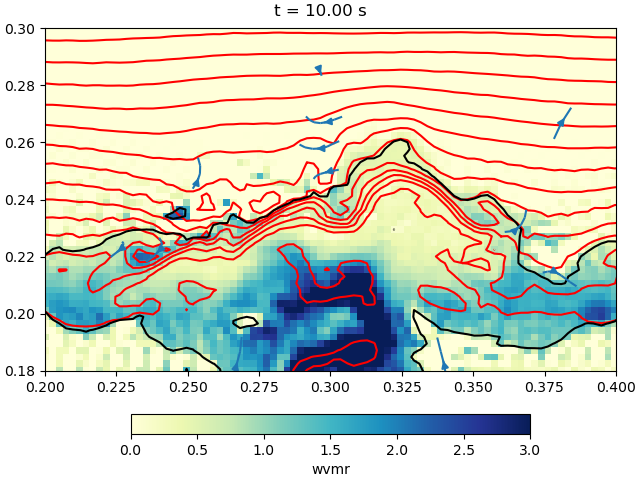

In [33]:
# Plotting loop
fig = plt.figure(constrained_layout=True)
axs = plt.gca()

plots(fig, axs, -1)
decorate_cb(fig, axs, -1)

def animate(step):
    axs.clear()

    plots(fig, axs, step)
    
Writer = animation.writers['ffmpeg']
writer = Writer(fps=4, bitrate=-1)

anim = animation.FuncAnimation(fig, animate, interval=250, frames=list(range(t0_idx, NSAMP)), repeat=True)
plt.show()